In [8]:
# Welcome to my Wikipedia Game AI!

# This project simulates the challenge of trying to get from one Wiki page to another using only hyperlinks
# contained within different Wiki pages. The goal of the game is for two people (or in this case, an AI) 
# to use the least amount of intermediate Wiki pages when traveling from the origin to the target page.

#If you want to try out the AI with two of your own chosen Wiki pages, first run the next 4 cells to
#set up the project, which involves importing the GloVe and Wikipedia API's, and defining the functions to be used.
# If you get an error that is unrelated to the a wrong name for a Wiki page, you must restart the kernal and rerun all the 
# set up cells again

In [9]:
#this will take a short while...
import sys
# !{sys.executable} -m pip install gensim
import gensim.downloader as api
w2v_embedding = api.load("glove-wiki-gigaword-100")

In [10]:
#Found it easier to use my own cosine similarity function
from numpy import dot
from numpy.linalg import norm
 
def cos_sim(v1,v2): #this compute the same values as the build in w2v_embedding.similarity function
    return dot(v1, v2)/(norm(v1)*norm(v2))

In [4]:
#only single word pages
import numpy as np
import wikipediaapi 
wiki = wikipediaapi.Wikipedia('en')

def sortLinksSemanticallySingle(currentPage,target,intermediateLinks):
    
    print("Path",intermediateLinks)
    pageSimilarity = {} #key is page, value is semantic similarity with target
    for link in currentPage.links.keys():
        try:
            
            link_embedding = w2v_embedding[link.lower()]
            target_embedding = w2v_embedding[target.lower()]
            try:
                pageSimilarity[link] = cos_sim(link_embedding,target_embedding)
            except:
                pass                    
        
        except:
            pass
    
    sorted_keys = sorted(pageSimilarity, key=pageSimilarity.get)
    max_key = max(pageSimilarity, key=pageSimilarity.get)
    while(max_key.capitalize() in intermediateLinks):
        del pageSimilarity[max_key]
        max_key = max(pageSimilarity, key=pageSimilarity.get)
    max_score = pageSimilarity[max_key]
    
    if target.capitalize() in pageSimilarity.keys():
        return intermediateLinks
    else:
        print("Current Page:",max_key," - ",max_score,"to target")
        intermediateLinks.append(max_key.capitalize())
        nextPage = wiki.page(max_key.replace(" ", "_"))
        sortLinksSemanticallySingle(nextPage,target,intermediateLinks)
        return intermediateLinks

def findDistanceSingle(origin,target):
    originPage = wiki.page(origin)
#     print("Running findDistance")
    targetPage = wiki.page(target)
    print("Initial Page:",wiki.extracts(originPage,exsentences=1))
    print("Target Page:",wiki.extracts(targetPage,exsentences=1))
    if(originPage.exists()):
        if(targetPage.exists()):
            intermediateLinks = []
           
            try:
                print("caling sortlinks")
                sequence = sortLinksSemanticallySingle(originPage,target,intermediateLinks)
            except:
                
                return 1000
#             print(sequence)
        else:
            return 0,0
    else:
        return 0,0
    print("\nDegrees of separation from",origin,"-->",target,":",len(sequence))
    print(sequence)
#     return len(sequence)

In [7]:
#Includes mulit-word Wiki pages
#Sums each words' embedding in the title of a wiki page to compute the page's representation
import numpy as np
import string
import wikipediaapi 
wiki = wikipediaapi.Wikipedia('en')
def sortLinksSemanticallySummingDisplay(currentPage,target,intermediateLinks,max,visitedLinks):
    print("Current Path:",intermediateLinks)
    print("Pages visited:",visitedLinks)
    pageSimilarity = {} #key is page, value is semantic similarity with target
    target_embedding = 0
    for word in target.lower().split():
        try:
            target_embedding +=w2v_embedding[word]
        except:
            pass
    for link in currentPage.links.keys():
        
        try:
            link_embedding = 0
            for word in link.lower().split():
            
                word = word.replace(",","")
                word = word.replace("portal:","")
                word = word.replace("category:","")
                word = word.replace("talk:","")
                word = word.replace("template:","")
                word = word.replace("help:","")
                word = word.replace("file:","")
                word = word.replace("wikipedia:","")
                try:
                    link_embedding += w2v_embedding[word]
                except:
                    pass
            if isinstance(link_embedding,np.ndarray):
#                 
                pageSimilarity[link] = cos_sim(link_embedding,target_embedding)
            else:
                pass
        except:
            pass
   
    if target in pageSimilarity.keys():
#         print("found it!")
#         print("Degrees of separation from",origin,"-->",target,":",len(sequence))
#         print(intermediateLinks)
        return intermediateLinks, max, visitedLinks
    else:
        max_key = None
        for key in pageSimilarity.keys():
            if pageSimilarity[key] > max and key.capitalize() not in visitedLinks:
                if pageSimilarity[key] < .8:
                    try:
                        link_obj = wiki.page(key)
                        try:
                            utility_of_link = len(link_obj.links)
                        except:
                            utility_of_link = 10
                        if utility_of_link > 500:
                            max = pageSimilarity[key]
                            max_key = key
        
                    except:
                        pass
                else:
                    link_obj = wiki.page(key)
                    utility_of_link = len(link_obj.links)
                    if utility_of_link > 100:
                        max = pageSimilarity[key]
                        max_key = key
        if max_key is None:
            print("backtracking...")
            previous = intermediateLinks[-2]
            intermediateLinks = intermediateLinks[:-1]
            
            previousPageEmbedding = 0
            print("previous:",previous)
            for word in previous.lower().split():
            
                word = word.replace(",","")
                word = word.replace("portal:","")
                word = word.replace("category:","")
                word = word.replace("talk:","")
                word = word.replace("template:","")
                word = word.replace("help:","")
                word = word.replace("file:","")
                word = word.replace("wikipedia:","")
                try:
                    previousPageEmbedding += w2v_embedding[word]
                except:
                    pass
            max = cos_sim(previousPageEmbedding,target_embedding)
            print(max)
    
            tempPrevious = previous.replace(" ", "_")
            previousPage = wiki.page(tempPrevious)
            if not previousPage.exists():  
                print("couldnt find page for",tempPrevious)
                previous = string.capwords(previous)
                previous = previous.replace(" ", "_")
                print("trying to find page for",previous)
                previousPage = wiki.page(previous)
            sortLinksSemanticallySummingDisplay(previousPage,target,intermediateLinks,max,visitedLinks)
        else:
            print("Current Page:",max_key," - ",max,"to target")
            intermediateLinks.append(max_key.capitalize())
            visitedLinks.append(max_key.capitalize())
            
            
            temp_max_key = max_key.replace(" ", "_")
            nextPage = wiki.page(temp_max_key)
            if not nextPage.exists(): 
                print("page doesn't exist for",temp_max_key)
                max_key = string.capwords(max_key)
                max_key = max_key.replace(" ", "_")
                print("attempting to find page for",max_key)
                nextPage = wiki.page(max_key)
    
    
            sortLinksSemanticallySummingDisplay(nextPage,target,intermediateLinks,max,visitedLinks)
        return intermediateLinks, max, visitedLinks

def findDistanceSummingDisplay(origin,target):
    originPage = wiki.page(origin)
    targetPage = wiki.page(target)
    print("Initial Page:",wiki.extracts(originPage,exsentences=1))
    print("Target Page:",wiki.extracts(targetPage,exsentences=1))
    if(originPage.exists()):
        if(targetPage.exists()):
            intermediateLinks = []
            visitedLinks = []
            try:
                sequence, max, finalVisitedLinks = sortLinksSemanticallySummingDisplay(originPage,target,intermediateLinks, 0,visitedLinks)
            except:
                return 0,0
                pass
        else:
            print(targetPage,"is not a page on Wiki")
    else:
            print(originPage,"is not a page on Wiki")
    print("\n Degrees of separation from",origin,"-->",target,":",len(sequence))
    print("Final path of intermediate links:",sequence)
    
    return 

In [11]:
# The findDistanceSingle function only takes single word wiki pages as arguments

#Run this example, or replace the arguements with single word Wiki pages. Capitlization matters
findDistanceSingle("Cat", "Computer")

Initial Page: The cat (Felis catus) is a domestic species of small carnivorous mammal.
Target Page: A computer is a machine that can be programmed to carry out sequences of arithmetic or logical operations (computation) automatically.
caling sortlinks
Path []
Current Page: Microsoft  -  0.68780464 to target
Path ['Microsoft']
Current Page: Software  -  0.8373123 to target
Path ['Microsoft', 'Software']
Current Page: Programmer  -  0.5939966 to target
Path ['Microsoft', 'Software', 'Programmer']
Current Page: IBM  -  0.676206 to target
Path ['Microsoft', 'Software', 'Programmer', 'Ibm']
Current Page: Intel  -  0.606277 to target
Path ['Microsoft', 'Software', 'Programmer', 'Ibm', 'Intel']
Current Page: Technology  -  0.76421595 to target
Path ['Microsoft', 'Software', 'Programmer', 'Ibm', 'Intel', 'Technology']

Degrees of separation from Cat --> Computer : 6
['Microsoft', 'Software', 'Programmer', 'Ibm', 'Intel', 'Technology']


In [12]:
#The findDistanceAverage search includes mulit-word Wiki pages. This means that in addition to being able to
#use Wiki pages with titles that are more than one word, the origin and / or target Wiki pages can also be multi-word pages.

#Run this example, or replace the arguements with single or multi-word Wiki pages. Capitlization matters
findDistanceSummingDisplay("Computational theory of mind", "Potato")

Initial Page: In philosophy of mind, the computational theory of mind (CTM), also known as computationalism, is a family of views that hold that the human mind is an information processing system and that cognition and consciousness together are a form of computation.
Target Page: The potato is a starchy food, a tuber of the plant Solanum tuberosum and is a root vegetable native to the Americas.
Current Path: []
Pages visited: []
Current Page: Natural selection  -  0.2917805 to target
Current Path: ['Natural selection']
Pages visited: ['Natural selection']
Current Page: Evolution of fish  -  0.37907445 to target
Current Path: ['Natural selection', 'Evolution of fish']
Pages visited: ['Natural selection', 'Evolution of fish']
Current Page: Fish farming  -  0.61032027 to target
Current Path: ['Natural selection', 'Evolution of fish', 'Fish farming']
Pages visited: ['Natural selection', 'Evolution of fish', 'Fish farming']
Current Page: Cheese  -  0.7155594 to target
Current Path: ['Natur

In [ ]:
# the rest of the cells are for data collection and other experiments, and can be ignored

In [4]:
#averaging
import numpy as np
import wikipediaapi 
wiki = wikipediaapi.Wikipedia('en')

def sortLinksSemanticallyAverage(currentPage,target,intermediateLinks):
    
    pageSimilarity = {} #key is page, value is semantic similarity with target
    for link in currentPage.links.keys():
        try:
            link_embedding = 0
            vov = []
            for word in link.lower().split():
                word = word.replace(",","")
                vov.append(w2v_embedding[word])
            vov = np.array(vov)
            link_embedding = np.average(vov,axis=0)
            target_embedding = w2v_embedding[target]
            pageSimilarity[link] = cos_sim(link_embedding,target_embedding)
            
        except:
            pass
    
    sorted_keys = sorted(pageSimilarity, key=pageSimilarity.get)
    max_key = max(pageSimilarity, key=pageSimilarity.get)
    while(max_key.capitalize() in intermediateLinks):
        del pageSimilarity[max_key]
        max_key = max(pageSimilarity, key=pageSimilarity.get)
    
   
    if target.capitalize() in pageSimilarity.keys():
        return intermediateLinks
    else:
        intermediateLinks.append(max_key.capitalize())
        nextPage = wiki.page(max_key.replace(" ", "_"))
        sortLinksSemanticallyAverage(nextPage,target,intermediateLinks)
        return intermediateLinks

def findDistanceAverage(origin,target):
    print("running findDistance")
    try:
        w2v_embedding.similarity(origin,target)
        originPage = wiki.page(origin.capitalize())
        targetPage = wiki.page(target.capitalize())
        print(wiki.extracts(originPage,exsentences=1))
        print(wiki.extracts(targetPage,exsentences=1))
        if(originPage.exists()):
            if(targetPage.exists()):
                intermediateLinks = []
                sequence = sortLinksSemanticallyAverage(originPage,target,intermediateLinks)
            else:
                print(targetPage,"is not a page on Wiki")
        else:
                print(originPage,"is not a page on Wiki")
        print("Degrees of separation from",origin,"-->",target,":",len(sequence))
        print(sequence)
    except:
        print("an exception occured")
        pass

In [2]:
#unused function for testing
def averageWordsInSummarySimilarity(currentPage,targetWord): 
    scores = [] 
    for word in currentPage.summary.splits(" "): 
        try: 
            print(word)
            scores.append( w2v_embedding.similarity(word,target))
        except: 
            pass
    return mean(scores)

In [7]:
#summing
import numpy as np
import wikipediaapi 
wiki = wikipediaapi.Wikipedia('en')

def sortLinksSemanticallySummingDataCollection(currentPage,target,intermediateLinks,max,visitedLinks):
    pageSimilarity = {} #key is page, value is semantic similarity with target
    target_embedding = 0
    for word in target.lower().split():
        target_embedding +=w2v_embedding[word]

    for link in currentPage.links.keys():
        try:
            link_embedding = 0
            for word in link.lower().split():
            
                word = word.replace(",","")
                word = word.replace("portal:","")
                word = word.replace("category:","")
                word = word.replace("talk:","")
                word = word.replace("template:","")
                word = word.replace("help:","")
                word = word.replace("file:","")
                word = word.replace("wikipedia:","")
                try:
                    link_embedding += w2v_embedding[word]
                except:
                    pass
            if isinstance(link_embedding,np.ndarray):
#                 
                pageSimilarity[link] = cos_sim(link_embedding,target_embedding)
            else:
                pass
        except:
            pass
    
    
   
    if target in pageSimilarity.keys():
        return intermediateLinks, max, visitedLinks
    else:
        max_key = None
        for key in pageSimilarity.keys():
            if pageSimilarity[key] > max and key.capitalize() not in visitedLinks:
                if pageSimilarity[key] < .8:
                    link_obj = wiki.page(key)
                    utility_of_link = len(link_obj.links)
                    if utility_of_link > 500:
                        max = pageSimilarity[key]
                        max_key = key
                    else:
                        pass
                else:
                    link_obj = wiki.page(key)
                    utility_of_link = len(link_obj.links)
                    if utility_of_link > 100:
                        max = pageSimilarity[key]
                        max_key = key
        if max_key is None:
#             print("backtracking...")
            previous = intermediateLinks[-2]
            previousPage = wiki.page(previous.replace(" ", "_"))
#             visitedLinks = intermediateLinks
#             visitedLinks.append(intermediateLinks[-1])
            intermediateLinks = intermediateLinks[:-1]
            
            previousPageEmbedding = 0
#             print("previous:",previous)
            for word in previous.lower().split():
            
                word = word.replace(",","")
                word = word.replace("portal:","")
                word = word.replace("category:","")
                word = word.replace("talk:","")
                word = word.replace("template:","")
                word = word.replace("help:","")
                word = word.replace("file:","")
                word = word.replace("wikipedia:","")
#                 print(word)
                try:
#                     print(w2v_embedding[word])
                    previousPageEmbedding += w2v_embedding[word]
                except:
                    pass
            max = cos_sim(previousPageEmbedding,target_embedding)
#             print(max)
    
    
            sortLinksSemanticallySummingDataCollection(previousPage,target,intermediateLinks,max,visitedLinks)
        else:
#             print(max_key,max)
    #         print("not found yet")
            intermediateLinks.append(max_key.capitalize())
            visitedLinks.append(max_key.capitalize())
            nextPage = wiki.page(max_key.replace(" ", "_"))
    #         visitedLinks = intermediateLinks
            sortLinksSemanticallySummingDataCollection(nextPage,target,intermediateLinks,max,visitedLinks)
        return intermediateLinks, max, visitedLinks
#     return intermediateLinks, max, visitedLinks

def findDistanceSummingDataCollection(origin,target):
    print("Running findDistance")
    originPage = wiki.page(origin)
    targetPage = wiki.page(target)
#     print(targetPage.exists())
#     print(targetPage.fullurl)
#     print(targetPage.title)
#         print("originPage:",originPage)
#         print("targetPage:",targetPage)
#         print(originPage.title)
#         print(targetPage.title)
#     print(wiki.extracts(originPage,exsentences=1))
    print("Initial Page:",wiki.extracts(originPage,exsentences=1))
    print("Target Page:",wiki.extracts(targetPage,exsentences=1))
    if(originPage.exists()):
        if(targetPage.exists()):
            intermediateLinks = []
            visitedLinks = []
            try:
                print("caling sortlinks")
                sequence, max, finalVisitedLinks = sortLinksSemanticallySummingDataCollection(originPage,target,intermediateLinks, 0,visitedLinks)
            except:
                
                return 0,0
#                 pass
            print(sequence)
            print(finalVisitedLinks)
        else:
            return 0,0
    else:
        return 0,0
    return len(sequence),len(finalVisitedLinks)

In [76]:
degreesSingle = []
degreesMulti = []

In [77]:
degree = findDistanceSummingDisplay("Electromagnetism", "Lake")
degreesMulti.append(degree)

Initial Page: Electromagnetism is a branch of physics involving the study of the electromagnetic force, a type of physical interaction that occurs between electrically charged particles.
Target Page: A lake is an area filled with water, localized in a basin, surrounded by land, and set apart from any river or other outlet that serves to feed or drain the lake.
Current path: []
Pages visited: []
Alaska 0.54677516
Current path: ['Alaska']
Pages visited: ['Alaska']
Colorado River 0.760707
Current path: ['Alaska', 'Colorado river']
Pages visited: ['Alaska', 'Colorado river']
Lake Mead 0.9102244
Current path: ['Alaska', 'Colorado river', 'Lake mead']
Pages visited: ['Alaska', 'Colorado river', 'Lake mead']
Degrees of separation from Electromagnetism --> Lake : 3
['Alaska', 'Colorado river', 'Lake mead']


In [78]:
degree = findDistanceSingle("Electromagnetism", "Lake")
degreesSingle.append(degree)

Running findDistance
Initial Page: Electromagnetism is a branch of physics involving the study of the electromagnetic force, a type of physical interaction that occurs between electrically charged particles.
Target Page: A lake is an area filled with water, localized in a basin, surrounded by land, and set apart from any river or other outlet that serves to feed or drain the lake.
caling sortlinks
[]
Alaska 0.54677516
['Alaska']
Utah 0.53627855
['Alaska', 'Utah']
Montana 0.50585765
['Alaska', 'Utah', 'Montana']
County 0.53242743
['Alaska', 'Utah', 'Montana', 'County']
Township 0.54390454
['Alaska', 'Utah', 'Montana', 'County', 'Township']
Village 0.5401419
['Alaska', 'Utah', 'Montana', 'County', 'Township', 'Village']
Island 0.5870456
['Alaska', 'Utah', 'Montana', 'County', 'Township', 'Village', 'Island']
Shore 0.6264014
['Alaska', 'Utah', 'Montana', 'County', 'Township', 'Village', 'Island', 'Shore']
['Alaska', 'Utah', 'Montana', 'County', 'Township', 'Village', 'Island', 'Shore']
De

In [79]:
degreesMulti

[3]

In [80]:
degree = findDistanceSummingDisplay("Anxiety", "Electroencephalography")
degreesMulti.append(degree)

Initial Page: Anxiety is an emotion characterized by an unpleasant state of inner turmoil and includes subjectively unpleasant feelings of dread over anticipated events.
Target Page: Electroencephalography (EEG) is a method to record an electrogram of the electrical activity on the scalp that has been shown to represent the macroscopic activity of the surface layer of the brain underneath.
Current path: []
Pages visited: []
Positron emission tomography 0.34042275
Current path: ['Positron emission tomography']
Pages visited: ['Positron emission tomography']
Perfusion 0.4172318
Current path: ['Positron emission tomography', 'Perfusion']
Pages visited: ['Positron emission tomography', 'Perfusion']
Electrocardiography 0.61496073
Current path: ['Positron emission tomography', 'Perfusion', 'Electrocardiography']
Pages visited: ['Positron emission tomography', 'Perfusion', 'Electrocardiography']
Degrees of separation from Anxiety --> Electroencephalography : 3
['Positron emission tomography',

In [81]:
degree = findDistanceSingle("Anxiety", "Electroencephalography")
degreesSingle.append(degree)

Running findDistance
Initial Page: Anxiety is an emotion characterized by an unpleasant state of inner turmoil and includes subjectively unpleasant feelings of dread over anticipated events.
Target Page: Electroencephalography (EEG) is a method to record an electrogram of the electrical activity on the scalp that has been shown to represent the macroscopic activity of the surface layer of the brain underneath.
caling sortlinks
[]
Stimulation 0.4314241
['Stimulation']
Arousal 0.33144826
['Stimulation', 'Arousal']
['Stimulation', 'Arousal']
Degrees of separation from Anxiety --> Electroencephalography : 2
['Stimulation', 'Arousal']


In [82]:
degree = findDistanceSummingDisplay("Feces", "Theatre")
degreesMulti.append(degree)

Initial Page: Feces (or faeces) is the solid or semi-solid remains of food that was not digested in the small intestine, and has been broken down by bacteria in the large intestine.
Target Page: Theatre or theater is a collaborative form of performing art that uses live performers, usually actors or actresses, to present the experience of a real or imagined event before a live audience in a specific place, often a stage.
Current path: []
Pages visited: []
Science 0.4033437
Current path: ['Science']
Pages visited: ['Science']
Academy 0.6424194
Current path: ['Science', 'Academy']
Pages visited: ['Science', 'Academy']
Royal Academy of Music 0.6604944
Current path: ['Science', 'Academy', 'Royal academy of music']
Pages visited: ['Science', 'Academy', 'Royal academy of music']
Opera 0.7293995
Current path: ['Science', 'Academy', 'Royal academy of music', 'Opera']
Pages visited: ['Science', 'Academy', 'Royal academy of music', 'Opera']
Degrees of separation from Feces --> Theatre : 4
['Scie

In [83]:
degree = findDistanceSingle("Feces", "Theatre")
degreesSingle.append(degree)

Running findDistance
Initial Page: Feces (or faeces) is the solid or semi-solid remains of food that was not digested in the small intestine, and has been broken down by bacteria in the large intestine.
Target Page: Theatre or theater is a collaborative form of performing art that uses live performers, usually actors or actresses, to present the experience of a real or imagined event before a live audience in a specific place, often a stage.
caling sortlinks
[]
Science 0.4033437
['Science']
Academy 0.6424194
['Science', 'Academy']
Arts 0.67265415
['Science', 'Academy', 'Arts']
['Science', 'Academy', 'Arts']
Degrees of separation from Feces --> Theatre : 3
['Science', 'Academy', 'Arts']


In [84]:
degreesMulti

[3, 3, 4]

In [85]:
degree = findDistanceSummingDisplay("Trade", "Mango")
degreesMulti.append(degree)

Initial Page: Trade involves the transfer of goods and services from one person or entity to another, often in exchange for money.
Target Page: A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.
Current path: []
Pages visited: []
Coconut 0.7658856
Current path: ['Coconut']
Pages visited: ['Coconut']
backtracking...


In [149]:
degree = findDistanceSingle("Trade", "Mango")
degreesSingle.insert(3,degree)

Running findDistance
Initial Page: Trade involves the transfer of goods and services from one person or entity to another, often in exchange for money.
Target Page: A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.
caling sortlinks
[]
Coconut 0.7658856
['Coconut']
Avocado 0.7857657
['Coconut', 'Avocado']
Pear 0.7619122
['Coconut', 'Avocado', 'Pear']
Banana 0.7054824
['Coconut', 'Avocado', 'Pear', 'Banana']
Fruit 0.70177424
['Coconut', 'Avocado', 'Pear', 'Banana', 'Fruit']
['Coconut', 'Avocado', 'Pear', 'Banana', 'Fruit']
Degrees of separation from Trade --> Mango : 5
['Coconut', 'Avocado', 'Pear', 'Banana', 'Fruit']


In [148]:
degreesSingle

[8, 2, 3, 1, 20, 2, 7, 11, 3, 3, 9, 1, 3, 5, 0, 3, 1, 1, 2, 3, 6, 5, 3, 7]

In [87]:
degree = findDistanceSummingDisplay("Mutation", "Neuroscience")
degreesMulti.append(degree)

Initial Page: In biology, a mutation is an alteration in the nucleic acid sequence of the genome of an organism, virus, or extrachromosomal DNA. Viral genomes contain either DNA or RNA. Mutations result from errors during DNA or viral replication, mitosis, or meiosis or other types of damage to DNA (such as pyrimidine dimers caused by exposure to ultraviolet radiation), which then may undergo error-prone repair (especially microhomology-mediated end joining), cause an error during other forms of repair, or cause an error during replication (translesion synthesis).
Target Page: Neuroscience is the scientific study of the nervous system.
Current path: []
Pages visited: []
Evolutionary neuroscience 0.88140506
Current path: ['Evolutionary neuroscience']
Pages visited: ['Evolutionary neuroscience']
Degrees of separation from Mutation --> Neuroscience : 1
['Evolutionary neuroscience']


In [88]:
degree = findDistanceSingle("Mutation", "Neuroscience")
degreesSingle.append(degree)

Running findDistance
Initial Page: In biology, a mutation is an alteration in the nucleic acid sequence of the genome of an organism, virus, or extrachromosomal DNA. Viral genomes contain either DNA or RNA. Mutations result from errors during DNA or viral replication, mitosis, or meiosis or other types of damage to DNA (such as pyrimidine dimers caused by exposure to ultraviolet radiation), which then may undergo error-prone repair (especially microhomology-mediated end joining), cause an error during other forms of repair, or cause an error during replication (translesion synthesis).
Target Page: Neuroscience is the scientific study of the nervous system.
caling sortlinks
[]
Genetics 0.7483798
['Genetics']
['Genetics']
Degrees of separation from Mutation --> Neuroscience : 1
['Genetics']


In [89]:
degree = findDistanceSummingDisplay("Eukaryote", "Game")
degreesMulti.append(degree)

Initial Page: Eukaryotes () are organisms whose cells have a nucleus enclosed within a nuclear envelope.
Target Page: A game is a structured form of play, usually undertaken for entertainment or fun, and sometimes used as an educational tool.
Current path: []
Pages visited: []
The New York Times 0.5771679
Current path: ['The new york times']
Pages visited: ['The new york times']
Video game 0.89016205
Current path: ['The new york times', 'Video game']
Pages visited: ['The new york times', 'Video game']
Degrees of separation from Eukaryote --> Game : 2
['The new york times', 'Video game']


In [90]:
degree = findDistanceSingle("Eukaryote", "Game")
degreesSingle.append(degree)

Running findDistance
Initial Page: Eukaryotes () are organisms whose cells have a nucleus enclosed within a nuclear envelope.
Target Page: A game is a structured form of play, usually undertaken for entertainment or fun, and sometimes used as an educational tool.
caling sortlinks
[]
Life 0.48069265
['Life']
Time 0.68046665
['Life', 'Time']
Season 0.77331936
['Life', 'Time', 'Season']
History 0.5629132
['Life', 'Time', 'Season', 'History']
Past 0.5599439
['Life', 'Time', 'Season', 'History', 'Past']
Minute 0.5287671
['Life', 'Time', 'Season', 'History', 'Past', 'Minute']
Second 0.6956585
['Life', 'Time', 'Season', 'History', 'Past', 'Minute', 'Second']
Week 0.5775604
['Life', 'Time', 'Season', 'History', 'Past', 'Minute', 'Second', 'Week']
Day 0.5654173
['Life', 'Time', 'Season', 'History', 'Past', 'Minute', 'Second', 'Week', 'Day']
Night 0.6454075
['Life', 'Time', 'Season', 'History', 'Past', 'Minute', 'Second', 'Week', 'Day', 'Night']
Summer 0.48821682
['Life', 'Time', 'Season', 'Hist

In [91]:
degree = findDistanceSummingDisplay("Anesthesia", "Tasmania")
degreesMulti.append(degree)

Initial Page: Anesthesia is a state of controlled, temporary loss of sensation or awareness that is induced for medical purposes.
Target Page: Tasmania () (Nuenonne/Palawa kani: lutruwita) is an island state of Australia.
Current path: []
Pages visited: []
Launceston, Tasmania 0.9456699
Current path: ['Launceston, tasmania']
Pages visited: ['Launceston, tasmania']
Degrees of separation from Anesthesia --> Tasmania : 1
['Launceston, tasmania']


In [92]:
degree = findDistanceSingle("Anesthesia", "Tasmania")
degreesSingle.append(degree)

Running findDistance
Initial Page: Anesthesia is a state of controlled, temporary loss of sensation or awareness that is induced for medical purposes.
Target Page: Tasmania () (Nuenonne/Palawa kani: lutruwita) is an island state of Australia.
caling sortlinks
[]
Prehistory 0.19140448
['Prehistory']
Perth 0.6442722
['Prehistory', 'Perth']
['Prehistory', 'Perth']
Degrees of separation from Anesthesia --> Tasmania : 2
['Prehistory', 'Perth']


In [93]:
degree = findDistanceSummingDisplay("Oxycodone", "Comedian")
degreesMulti.append(degree)

Initial Page: Oxycodone, sold under the brand names Roxicodone and OxyContin (which is the extended release form) among others, is a semi-synthetic  opioid medication used for treatment of moderate to severe pain.
Target Page: A comedian (fem.
Current path: []
Pages visited: []
Stoner film 0.5082199
Current path: ['Stoner film']
Pages visited: ['Stoner film']
Degrees of separation from Oxycodone --> Comedian : 1
['Stoner film']


In [94]:
degree = findDistanceSingle("Oxycodone", "Comedian")
degreesSingle.append(degree)

Running findDistance
Initial Page: Oxycodone, sold under the brand names Roxicodone and OxyContin (which is the extended release form) among others, is a semi-synthetic  opioid medication used for treatment of moderate to severe pain.
Target Page: A comedian (fem.
caling sortlinks
[]
Bartender 0.45684925
['Bartender']
Restaurateur 0.51865065
['Bartender', 'Restaurateur']
Chef 0.4531261
['Bartender', 'Restaurateur', 'Chef']
Baker 0.3493629
['Bartender', 'Restaurateur', 'Chef', 'Baker']
Restaurant 0.23915133
['Bartender', 'Restaurateur', 'Chef', 'Baker', 'Restaurant']
Seinfeld 0.53707874
['Bartender', 'Restaurateur', 'Chef', 'Baker', 'Restaurant', 'Seinfeld']
Sitcom 0.6029271
['Bartender', 'Restaurateur', 'Chef', 'Baker', 'Restaurant', 'Seinfeld', 'Sitcom']
['Bartender', 'Restaurateur', 'Chef', 'Baker', 'Restaurant', 'Seinfeld', 'Sitcom']
Degrees of separation from Oxycodone --> Comedian : 7
['Bartender', 'Restaurateur', 'Chef', 'Baker', 'Restaurant', 'Seinfeld', 'Sitcom']


In [98]:
degree = findDistanceSummingDisplay("Diplomacy", "Uterus")
degreesMulti.append(degree)


Initial Page: Diplomacy refers to spoken or written speech acts by representatives of states (such as leaders and diplomats) intended to influence events in the international system.Diplomacy is the main instrument of foreign policy and global governance which represents the broader goals and strategies that guide a state's interactions with the rest of the world.
Target Page: The uterus (from Latin "uterus", plural uteri) or womb () is the main female hormone-responsive, secondary sex organ of the reproductive system in humans and most other mammals.
Current path: []
Pages visited: []
Tarim Basin 0.18761432
Current path: ['Tarim basin']
Pages visited: ['Tarim basin']
Turfan 0.19470924
Current path: ['Tarim basin', 'Turfan']
Pages visited: ['Tarim basin', 'Turfan']
Wonton 0.19556765
Current path: ['Tarim basin', 'Turfan', 'Wonton']
Pages visited: ['Tarim basin', 'Turfan', 'Wonton']
Frog legs 0.33839417
Current path: ['Tarim basin', 'Turfan', 'Wonton', 'Frog legs']
Pages visited: ['Tari

In [99]:
degree = findDistanceSingle("Diplomacy", "Uterus")
degreesSingle.append(degree)

Running findDistance
Initial Page: Diplomacy refers to spoken or written speech acts by representatives of states (such as leaders and diplomats) intended to influence events in the international system.Diplomacy is the main instrument of foreign policy and global governance which represents the broader goals and strategies that guide a state's interactions with the rest of the world.
Target Page: The uterus (from Latin "uterus", plural uteri) or womb () is the main female hormone-responsive, secondary sex organ of the reproductive system in humans and most other mammals.
caling sortlinks
[]
Consulate 0.16495824
['Consulate']
Omsk 0.12088105
['Consulate', 'Omsk']
T-80 0.17476657
['Consulate', 'Omsk', 'T-80']
Glacis 0.16978802
['Consulate', 'Omsk', 'T-80', 'Glacis']
Moat 0.25204703
['Consulate', 'Omsk', 'T-80', 'Glacis', 'Moat']
Palisade 0.21874617
['Consulate', 'Omsk', 'T-80', 'Glacis', 'Moat', 'Palisade']
Caltrop 0.21395534
['Consulate', 'Omsk', 'T-80', 'Glacis', 'Moat', 'Palisade', '

In [100]:
degree = findDistanceSummingDisplay("Andes", "Gasoline")
degreesMulti.append(degree)

Initial Page: The Andes, Andes Mountains or Andean Mountains (Spanish: Cordillera de los Andes) are the longest continental mountain range in the world, forming a continuous highland along the western edge of South America.
Target Page: Gasoline (American English; ) or petrol (British English; ) (see Etymology for naming differences and geographic usage) is a transparent, petroleum‑derived flammable liquid that is used primarily as a fuel in most spark-ignited internal combustion engines (also known as petrol engines).
Current path: []
Pages visited: []
Coffee 0.48732924
Current path: ['Coffee']
Pages visited: ['Coffee']
Coffee production in Colombia 0.545694
Current path: ['Coffee', 'Coffee production in colombia']
Pages visited: ['Coffee', 'Coffee production in colombia']
backtracking...
previous: Coffee
0.48732924
Current path: ['Coffee']
Pages visited: ['Coffee', 'Coffee production in colombia']
Futures contracts 0.53209376
Current path: ['Coffee', 'Futures contracts']
Pages visite

In [101]:
degree = findDistanceSingle("Andes", "Gasoline")
degreesSingle.append(degree)

Running findDistance
Initial Page: The Andes, Andes Mountains or Andean Mountains (Spanish: Cordillera de los Andes) are the longest continental mountain range in the world, forming a continuous highland along the western edge of South America.
Target Page: Gasoline (American English; ) or petrol (British English; ) (see Etymology for naming differences and geographic usage) is a transparent, petroleum‑derived flammable liquid that is used primarily as a fuel in most spark-ignited internal combustion engines (also known as petrol engines).
caling sortlinks
[]
Coffee 0.48732924
['Coffee']
Commodity 0.5117765
['Coffee', 'Commodity']
Propane 0.62392175
['Coffee', 'Commodity', 'Propane']
['Coffee', 'Commodity', 'Propane']
Degrees of separation from Andes --> Gasoline : 3
['Coffee', 'Commodity', 'Propane']


In [102]:
degree = findDistanceSummingDisplay("Eye", "Geek")
degreesMulti.append(degree)

Initial Page: Eyes are organs of the visual system.
Target Page: The word geek is a slang term originally used to describe eccentric or non-mainstream people; in current use, the word typically connotes an expert or enthusiast obsessed with a hobby or intellectual pursuit.
Current path: []
Pages visited: []
Rabbit 0.20475562
Current path: ['Rabbit']
Pages visited: ['Rabbit']
Pet 0.2910931
Current path: ['Rabbit', 'Pet']
Pages visited: ['Rabbit', 'Pet']
Werewolf 0.38047352
Current path: ['Rabbit', 'Pet', 'Werewolf']
Pages visited: ['Rabbit', 'Pet', 'Werewolf']
Tech noir 0.46867242
Current path: ['Rabbit', 'Pet', 'Werewolf', 'Tech noir']
Pages visited: ['Rabbit', 'Pet', 'Werewolf', 'Tech noir']
backtracking...
previous: Werewolf
0.38047352
Current path: ['Rabbit', 'Pet', 'Werewolf']
Pages visited: ['Rabbit', 'Pet', 'Werewolf', 'Tech noir']
Weird fiction 0.45567095
Current path: ['Rabbit', 'Pet', 'Werewolf', 'Weird fiction']
Pages visited: ['Rabbit', 'Pet', 'Werewolf', 'Tech noir', 'Weird

In [103]:
degree = findDistanceSingle("Eye", "Geek")
degreesSingle.append(degree)

Running findDistance
Initial Page: Eyes are organs of the visual system.
Target Page: The word geek is a slang term originally used to describe eccentric or non-mainstream people; in current use, the word typically connotes an expert or enthusiast obsessed with a hobby or intellectual pursuit.
caling sortlinks
[]
Image 0.25461447
['Image']
Video 0.28504053
['Image', 'Video']
Fanzine 0.37027404
['Image', 'Video', 'Fanzine']
['Image', 'Video', 'Fanzine']
Degrees of separation from Eye --> Geek : 3
['Image', 'Video', 'Fanzine']


In [104]:
degree = findDistanceSummingDisplay("Potato", "Stroke")
degreesMulti.append(degree)

Initial Page: The potato is a starchy tuber of the plant Solanum tuberosum and is a root vegetable native to the Americas.
Target Page: A stroke is a medical condition in which poor blood flow to the brain causes cell death.
Current path: []
Pages visited: []
Vitamin A 0.42240646
Current path: ['Vitamin a']
Pages visited: ['Vitamin a']
Ovarian cancer 0.5283634
Current path: ['Vitamin a', 'Ovarian cancer']
Pages visited: ['Vitamin a', 'Ovarian cancer']
Cancer 0.5534893
Current path: ['Vitamin a', 'Ovarian cancer', 'Cancer']
Pages visited: ['Vitamin a', 'Ovarian cancer', 'Cancer']
backtracking...
previous: Ovarian cancer
0.5283634
Current path: ['Vitamin a', 'Ovarian cancer']
Pages visited: ['Vitamin a', 'Ovarian cancer', 'Cancer']
Surgery 0.5471605
Current path: ['Vitamin a', 'Ovarian cancer', 'Surgery']
Pages visited: ['Vitamin a', 'Ovarian cancer', 'Cancer', 'Surgery']
Pain 0.5572281
Current path: ['Vitamin a', 'Ovarian cancer', 'Surgery', 'Pain']
Pages visited: ['Vitamin a', 'Ovarian

In [105]:
degree = findDistanceSingle("Potato", "Stroke")
degreesSingle.append(degree)

Running findDistance
Initial Page: The potato is a starchy tuber of the plant Solanum tuberosum and is a root vegetable native to the Americas.
Target Page: A stroke is a medical condition in which poor blood flow to the brain causes cell death.
caling sortlinks
[]
Cramps 0.46989465
['Cramps']
Pain 0.5572281
['Cramps', 'Pain']
Suffering 0.53041095
['Cramps', 'Pain', 'Suffering']
Cancer 0.5534893
['Cramps', 'Pain', 'Suffering', 'Cancer']
Surgery 0.5471605
['Cramps', 'Pain', 'Suffering', 'Cancer', 'Surgery']
Wound 0.63012046
['Cramps', 'Pain', 'Suffering', 'Cancer', 'Surgery', 'Wound']
Injury 0.57576287
['Cramps', 'Pain', 'Suffering', 'Cancer', 'Surgery', 'Wound', 'Injury']
Brain 0.5127434
['Cramps', 'Pain', 'Suffering', 'Cancer', 'Surgery', 'Wound', 'Injury', 'Brain']
Sleep 0.48005632
['Cramps', 'Pain', 'Suffering', 'Cancer', 'Surgery', 'Wound', 'Injury', 'Brain', 'Sleep']
['Cramps', 'Pain', 'Suffering', 'Cancer', 'Surgery', 'Wound', 'Injury', 'Brain', 'Sleep']
Degrees of separation fro

In [106]:
degree = findDistanceSummingDisplay("Continent", "Mind")
degreesMulti.append(degree)

Initial Page: A continent is any of several large landmasses.
Target Page: The mind is the set of faculties responsible for mental phenomena.
Current path: []
Pages visited: []
Nature 0.67752564
Current path: ['Nature']
Pages visited: ['Nature']
Degrees of separation from Continent --> Mind : 1
['Nature']


In [107]:
degree = findDistanceSingle("Continent", "Mind")
degreesSingle.append(degree)

Running findDistance
Initial Page: A continent is any of several large landmasses.
Target Page: The mind is the set of faculties responsible for mental phenomena.
caling sortlinks
[]
Nature 0.67752564
['Nature']
['Nature']
Degrees of separation from Continent --> Mind : 1
['Nature']


In [108]:
degree = findDistanceSummingDisplay("Fever", "Mind")
degreesMulti.append(degree)

Initial Page: Fever, also referred to as pyrexia, is defined as having a temperature above the normal range due to an increase in the body's temperature set point.
Target Page: The mind is the set of faculties responsible for mental phenomena.
Current path: []
Pages visited: []
Signs and symptoms 0.5263266
Current path: ['Signs and symptoms']
Pages visited: ['Signs and symptoms']
Emotion 0.6221164
Current path: ['Signs and symptoms', 'Emotion']
Pages visited: ['Signs and symptoms', 'Emotion']
Mind (journal) 1.0
Current path: ['Signs and symptoms', 'Emotion', 'Mind (journal)']
Pages visited: ['Signs and symptoms', 'Emotion', 'Mind (journal)']
backtracking...
previous: Emotion
0.6221164
Current path: ['Signs and symptoms', 'Emotion']
Pages visited: ['Signs and symptoms', 'Emotion', 'Mind (journal)']
Love 0.70630443
Current path: ['Signs and symptoms', 'Emotion', 'Love']
Pages visited: ['Signs and symptoms', 'Emotion', 'Mind (journal)', 'Love']
Philosophy of love 0.7422317
Current path: [

In [109]:
degree = findDistanceSummingDisplay("Fever", "Mind")
degreesSingle.append(degree)

Initial Page: Fever, also referred to as pyrexia, is defined as having a temperature above the normal range due to an increase in the body's temperature set point.
Target Page: The mind is the set of faculties responsible for mental phenomena.
Current path: []
Pages visited: []
Signs and symptoms 0.5263266
Current path: ['Signs and symptoms']
Pages visited: ['Signs and symptoms']
Emotion 0.6221164
Current path: ['Signs and symptoms', 'Emotion']
Pages visited: ['Signs and symptoms', 'Emotion']
Mind (journal) 1.0
Current path: ['Signs and symptoms', 'Emotion', 'Mind (journal)']
Pages visited: ['Signs and symptoms', 'Emotion', 'Mind (journal)']
backtracking...
previous: Emotion
0.6221164
Current path: ['Signs and symptoms', 'Emotion']
Pages visited: ['Signs and symptoms', 'Emotion', 'Mind (journal)']
Love 0.70630443
Current path: ['Signs and symptoms', 'Emotion', 'Love']
Pages visited: ['Signs and symptoms', 'Emotion', 'Mind (journal)', 'Love']
Philosophy of love 0.7422317
Current path: [

In [110]:
degree = findDistanceSummingDisplay("Abstinence", "Chinatown")
degreesMulti.append(degree)

Initial Page: Abstinence is a self-enforced restraint from indulging in bodily activities that are widely experienced as giving pleasure.
Target Page: A Chinatown (Chinese: 唐人街; pinyin: Tángrénjiē; Jyutping: tong4 jan4 gaai1) is an ethnic enclave of Chinese people located outside mainland China, Hong Kong, Macau, Singapore or Taiwan, most often in an urban setting.
Current path: []
Pages visited: []
Counterculture of the 1960s 0.32655504
Current path: ['Counterculture of the 1960s']
Pages visited: ['Counterculture of the 1960s']
Williamsburg, Brooklyn 0.589322
Current path: ['Counterculture of the 1960s', 'Williamsburg, brooklyn']
Pages visited: ['Counterculture of the 1960s', 'Williamsburg, brooklyn']
SoHo, Manhattan 0.67011595
Current path: ['Counterculture of the 1960s', 'Williamsburg, brooklyn', 'Soho, manhattan']
Pages visited: ['Counterculture of the 1960s', 'Williamsburg, brooklyn', 'Soho, manhattan']
Chinatown, Manhattan 0.8739396
Current path: ['Counterculture of the 1960s', '

In [111]:
degree = findDistanceSingle("Abstinence", "Chinatown")
degreesSingle.append(degree)

Running findDistance
Initial Page: Abstinence is a self-enforced restraint from indulging in bodily activities that are widely experienced as giving pleasure.
Target Page: A Chinatown (Chinese: 唐人街; pinyin: Tángrénjiē; Jyutping: tong4 jan4 gaai1) is an ethnic enclave of Chinese people located outside mainland China, Hong Kong, Macau, Singapore or Taiwan, most often in an urban setting.
caling sortlinks
[]
Prostitution 0.31236854
['Prostitution']
Manhattan 0.58033854
['Prostitution', 'Manhattan']
SoHo 0.63932675
['Prostitution', 'Manhattan', 'Soho']
Harlem 0.6078205
['Prostitution', 'Manhattan', 'Soho', 'Harlem']
Koreatown 0.653664
['Prostitution', 'Manhattan', 'Soho', 'Harlem', 'Koreatown']
['Prostitution', 'Manhattan', 'Soho', 'Harlem', 'Koreatown']
Degrees of separation from Abstinence --> Chinatown : 5
['Prostitution', 'Manhattan', 'Soho', 'Harlem', 'Koreatown']


In [112]:
degree = findDistanceSummingDisplay("Medicine", "Hospital")
degreesMulti.append(degree)

Initial Page: Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment,  palliation of their injury or disease, and promoting their health.
Target Page: A hospital is a health care institution providing patient treatment with specialized health science and auxiliary healthcare staff and medical equipment.
Current path: []
Pages visited: []
Degrees of separation from Medicine --> Hospital : 0
[]


In [113]:
degree = findDistanceSingle("Medicine", "Hospital")
degreesSingle.append(degree)

Running findDistance
Initial Page: Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment,  palliation of their injury or disease, and promoting their health.
Target Page: A hospital is a health care institution providing patient treatment with specialized health science and auxiliary healthcare staff and medical equipment.
caling sortlinks
[]
[]
Degrees of separation from Medicine --> Hospital : 0
[]


In [114]:
degree = findDistanceSummingDisplay("Prehistory", "Cavalry")
degreesMulti.append(degree)

Initial Page: Prehistory, also known as pre-literary history, is the period of human history between the use of the first stone tools by hominins c.
Target Page: Historically, cavalry (from the French word cavalerie, itself derived from "cheval" meaning "horse") are soldiers or warriors who fight mounted on horseback.
Current path: []
Pages visited: []
Roman Empire 0.40601915
Current path: ['Roman empire']
Pages visited: ['Roman empire']
Roman infantry tactics 0.7698245
Current path: ['Roman empire', 'Roman infantry tactics']
Pages visited: ['Roman empire', 'Roman infantry tactics']
Degrees of separation from Prehistory --> Cavalry : 2
['Roman empire', 'Roman infantry tactics']


In [115]:
degree = findDistanceSingle("Prehistory", "Cavalry")
degreesSingle.append(degree)

Running findDistance
Initial Page: Prehistory, also known as pre-literary history, is the period of human history between the use of the first stone tools by hominins c.
Target Page: Historically, cavalry (from the French word cavalerie, itself derived from "cheval" meaning "horse") are soldiers or warriors who fight mounted on horseback.
caling sortlinks
[]
Iron 0.27411336
['Iron']
Railroad 0.2893651
['Iron', 'Railroad']
Mobilization 0.3424439
['Iron', 'Railroad', 'Mobilization']
['Iron', 'Railroad', 'Mobilization']
Degrees of separation from Prehistory --> Cavalry : 3
['Iron', 'Railroad', 'Mobilization']


In [116]:
degree = findDistanceSummingDisplay("Racism", "Fantasy")
degreesMulti.append(degree)

Initial Page: Racism is the belief that groups of humans possess different behavioral traits corresponding to inherited attributes and can be divided based on the superiority of one race over another.
Target Page: Fantasy is a genre of speculative fiction involving magical elements, typically set in a fictional universe and sometimes inspired by mythology and folklore.
Current path: []
Pages visited: []
Book of Genesis 0.61908805
Current path: ['Book of genesis']
Pages visited: ['Book of genesis']
backtracking...


In [117]:
degree = findDistanceSingle("Racism", "Fantasy")
degreesSingle.append(degree)

Running findDistance
Initial Page: Racism is the belief that groups of humans possess different behavioral traits corresponding to inherited attributes and can be divided based on the superiority of one race over another.
Target Page: Fantasy is a genre of speculative fiction involving magical elements, typically set in a fictional universe and sometimes inspired by mythology and folklore.
caling sortlinks
[]
History 0.51331645
['History']
['History']
Degrees of separation from Racism --> Fantasy : 1
['History']


In [118]:
degree = findDistanceSummingDisplay("Biology", "Hypertension")
degreesMulti.append(degree)

Initial Page: Biology is the scientific study of life.
Target Page: Hypertension (HTN or HT), also known as high blood pressure (HBP), is a long-term medical condition in which the blood pressure in the arteries is persistently elevated.
Current path: []
Pages visited: []
Cholesterol 0.5831584
Current path: ['Cholesterol']
Pages visited: ['Cholesterol']
Degrees of separation from Biology --> Hypertension : 1
['Cholesterol']


In [119]:
degree = findDistanceSingle("Biology", "Hypertension")
degreesSingle.append(degree)

Running findDistance
Initial Page: Biology is the scientific study of life.
Target Page: Hypertension (HTN or HT), also known as high blood pressure (HBP), is a long-term medical condition in which the blood pressure in the arteries is persistently elevated.
caling sortlinks
[]
Cholesterol 0.5831584
['Cholesterol']
['Cholesterol']
Degrees of separation from Biology --> Hypertension : 1
['Cholesterol']


In [120]:
degree = findDistanceSummingDisplay("Ohio", "Ice")
degreesMulti.append(degree)

Initial Page: Ohio ( (listen)) is a state in the Midwestern region of the United States.
Target Page: Ice is water frozen into a solid state, typically forming at or below temperatures of 0 degrees Celsius or 32 degrees Fahrenheit.
Current path: []
Pages visited: []
Rock and roll 0.6026516
Current path: ['Rock and roll']
Pages visited: ['Rock and roll']
Soft rock 0.624398
Current path: ['Rock and roll', 'Soft rock']
Pages visited: ['Rock and roll', 'Soft rock']
backtracking...
previous: Rock and roll
0.6026516
Current path: ['Rock and roll']
Pages visited: ['Rock and roll', 'Soft rock']
backtracking...


In [121]:
degree = findDistanceSingle("Ohio", "Ice")
degreesSingle.append(degree)

Running findDistance
Initial Page: Ohio ( (listen)) is a state in the Midwestern region of the United States.
Target Page: Ice is water frozen into a solid state, typically forming at or below temperatures of 0 degrees Celsius or 32 degrees Fahrenheit.
caling sortlinks
[]
Iron 0.47039
['Iron']
Water 0.6125519
['Iron', 'Water']
['Iron', 'Water']
Degrees of separation from Ohio --> Ice : 2
['Iron', 'Water']


In [122]:
degree = findDistanceSummingDisplay("Paradox", "Tennessee")
degreesMulti.append(degree)

Initial Page: A paradox is a logically self-contradictory statement or a statement that runs contrary to one's expectation.
Target Page: Tennessee ( (listen) TEN-ih-SEE, locally  TEN-iss-ee), officially the State of Tennessee, is a state in the Southeastern region of the United States.
Current path: []
Pages visited: []
Argument from free will 0.33094934
Current path: ['Argument from free will']
Pages visited: ['Argument from free will']
George Berkeley 0.50917447
Current path: ['Argument from free will', 'George berkeley']
Pages visited: ['Argument from free will', 'George berkeley']
Bristol County, Massachusetts 0.6563232
Current path: ['Argument from free will', 'George berkeley', 'Bristol county, massachusetts']
Pages visited: ['Argument from free will', 'George berkeley', 'Bristol county, massachusetts']
Connecticut 0.74940497
Current path: ['Argument from free will', 'George berkeley', 'Bristol county, massachusetts', 'Connecticut']
Pages visited: ['Argument from free will', 'Geo

In [123]:
degree = findDistanceSingle("Paradox", "Tennessee")
degreesSingle.append(degree)

Running findDistance
Initial Page: A paradox is a logically self-contradictory statement or a statement that runs contrary to one's expectation.
Target Page: Tennessee ( (listen) TEN-ih-SEE, locally  TEN-iss-ee), officially the State of Tennessee, is a state in the Southeastern region of the United States.
caling sortlinks
[]
Barber 0.35313645
['Barber']
Flint 0.30873695
['Barber', 'Flint']
Ohio 0.81749314
['Barber', 'Flint', 'Ohio']
['Barber', 'Flint', 'Ohio']
Degrees of separation from Paradox --> Tennessee : 3
['Barber', 'Flint', 'Ohio']


In [124]:
degree = findDistanceSummingDisplay("Empire", "Synthesizer")
degreesMulti.append(degree)

Initial Page: An empire is a "political unit" made up of several territories and peoples, "usually created by conquest, and divided between a dominant center and subordinate peripheries".
Target Page: A synthesizer (also spelled synthesiser) is an electronic musical instrument that generates audio signals.
Current path: []
Pages visited: []
Cyrillic script 0.30058107
Current path: ['Cyrillic script']
Pages visited: ['Cyrillic script']
QWERTY keyboard 0.6819434
Current path: ['Cyrillic script', 'Qwerty keyboard']
Pages visited: ['Cyrillic script', 'Qwerty keyboard']
backtracking...
previous: Cyrillic script
0.30058107
Current path: ['Cyrillic script']
Pages visited: ['Cyrillic script', 'Qwerty keyboard']
Cipher runes 0.42898503
Current path: ['Cyrillic script', 'Cipher runes']
Pages visited: ['Cyrillic script', 'Qwerty keyboard', 'Cipher runes']
backtracking...
previous: Cyrillic script
0.30058107
Current path: ['Cyrillic script']
Pages visited: ['Cyrillic script', 'Qwerty keyboard', 'C

In [125]:
degree = findDistanceSingle("Empire", "Synthesizer")
degreesSingle.append(degree)

Running findDistance
Initial Page: An empire is a "political unit" made up of several territories and peoples, "usually created by conquest, and divided between a dominant center and subordinate peripheries".
Target Page: A synthesizer (also spelled synthesiser) is an electronic musical instrument that generates audio signals.
caling sortlinks
[]
Sinology 0.22658043
['Sinology']
Arabic 0.2698284
['Sinology', 'Arabic']
Fricative 0.39058167
['Sinology', 'Arabic', 'Fricative']
Bach 0.37706548
['Sinology', 'Arabic', 'Fricative', 'Bach']
Drum 0.6228025
['Sinology', 'Arabic', 'Fricative', 'Bach', 'Drum']
Orchestral 0.5764652
['Sinology', 'Arabic', 'Fricative', 'Bach', 'Drum', 'Orchestral']
['Sinology', 'Arabic', 'Fricative', 'Bach', 'Drum', 'Orchestral']
Degrees of separation from Empire --> Synthesizer : 6
['Sinology', 'Arabic', 'Fricative', 'Bach', 'Drum', 'Orchestral']


In [126]:
degree = findDistanceSummingDisplay("Spacecraft", "Writer")
degreesMulti.append(degree)

Initial Page: A spacecraft is a vehicle or machine designed to fly in outer space.
Target Page: A writer is a person who uses written words in different writing styles and techniques to communicate ideas.
Current path: []
Pages visited: []
Alan Shepard 0.4925686
Current path: ['Alan shepard']
Pages visited: ['Alan shepard']
Christian Scientist 0.58946335
Current path: ['Alan shepard', 'Christian scientist']
Pages visited: ['Alan shepard', 'Christian scientist']
backtracking...
previous: Alan shepard
0.4925686
Current path: ['Alan shepard']
Pages visited: ['Alan shepard', 'Christian scientist']
Portal:Biography 0.5817526
Current path: ['Alan shepard', 'Portal:biography']
Pages visited: ['Alan shepard', 'Christian scientist', 'Portal:biography']
Science fiction 0.59377426
Current path: ['Alan shepard', 'Portal:biography', 'Science fiction']
Pages visited: ['Alan shepard', 'Christian scientist', 'Portal:biography', 'Science fiction']
Astounding Award for Best New Writer 0.67684215
Current

Bengali science fiction 0.61068213


[8, 2, 3, 1, 20, 2, 7, 11, 3, 3, 9, 1, 3, 5, 0, 3, 1, 1, 2, 3, 6]

In [131]:
degree = findDistanceSingle("Spacecraft", "Writer")
degreesSingle.append(degree)

Running findDistance
Initial Page: A spacecraft is a vehicle or machine designed to fly in outer space.
Target Page: A writer is a person who uses written words in different writing styles and techniques to communicate ideas.
caling sortlinks
[]
Radio 0.3515439
['Radio']
Television 0.440814
['Radio', 'Television']
News 0.4854179
['Radio', 'Television', 'News']
Journalist 0.7907853
['Radio', 'Television', 'News', 'Journalist']
Columnist 0.7185005
['Radio', 'Television', 'News', 'Journalist', 'Columnist']
['Radio', 'Television', 'News', 'Journalist', 'Columnist']
Degrees of separation from Spacecraft --> Writer : 5
['Radio', 'Television', 'News', 'Journalist', 'Columnist']


In [132]:
degree = findDistanceSummingDisplay("Zionism", "Latitude")
degreesMulti.append(degree)

Initial Page: Zionism (Hebrew: צִיּוֹנוּת Tsiyyonut [tsijoˈnut] after Zion) is a nationalist movement that espouses the establishment of, and support for a homeland for the Jewish people centered in the area roughly corresponding to the Land of Israel, the region of Palestine, Canaan, or the Holy Land, on the basis of a long Jewish connection and attachment to that land.Modern Zionism emerged in the late 19th century in Central and Eastern Europe as a national revival movement, both in reaction to newer waves of antisemitism and as a response to Haskalah, or Jewish Enlightenment.
Target Page: In geography, latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.
Current path: []
Pages visited: []
Axis powers 0.3793975
Current path: ['Axis powers']
Pages visited: ['Axis powers']
backtracking...


In [133]:
degree = findDistanceSingle("Zionism", "Latitude")
degreesSingle.append(degree)

Running findDistance
Initial Page: Zionism (Hebrew: צִיּוֹנוּת Tsiyyonut [tsijoˈnut] after Zion) is a nationalist movement that espouses the establishment of, and support for a homeland for the Jewish people centered in the area roughly corresponding to the Land of Israel, the region of Palestine, Canaan, or the Holy Land, on the basis of a long Jewish connection and attachment to that land.Modern Zionism emerged in the late 19th century in Central and Eastern Europe as a national revival movement, both in reaction to newer waves of antisemitism and as a response to Haskalah, or Jewish Enlightenment.
Target Page: In geography, latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface.
caling sortlinks
[]
Iran 0.19795963
['Iran']
Radar 0.3009015
['Iran', 'Radar']
Azimuth 0.41664204
['Iran', 'Radar', 'Azimuth']
['Iran', 'Radar', 'Azimuth']
Degrees of separation from Zionism --> Latitude : 3
['Iran', 'Radar', 'Azimuth']


In [136]:
degree = findDistanceSummingDisplay("Bankruptcy", "Atmosphere")
degreesMulti.append(degree)

Initial Page: Bankruptcy is a legal process through which people or other entities who cannot repay debts to creditors may seek relief from some or all of their debts.
Target Page: An atmosphere (from Ancient Greek  ἀτμός (atmós) 'vapour, steam', and  σφαῖρα (sphaîra) 'sphere') is a layer of gas or layers of gases that envelope a planet, and is held in place by the gravity of the planetary body.
Current path: []
Pages visited: []
The People's Republic of China 0.4262636
Current path: ["The people's republic of china"]
Pages visited: ["The people's republic of china"]
Culture of China 0.51412433
Current path: ["The people's republic of china", 'Culture of china']
Pages visited: ["The people's republic of china", 'Culture of china']
Culture of Israel 0.52706
Current path: ["The people's republic of china", 'Culture of china', 'Culture of israel']
Pages visited: ["The people's republic of china", 'Culture of china', 'Culture of israel']
backtracking...
previous: Culture of china
0.5141243

In [139]:
degree = findDistanceSingle("Bankruptcy", "Atmosphere")
degreesSingle.append(degree)

Running findDistance
Initial Page: Bankruptcy is a legal process through which people or other entities who cannot repay debts to creditors may seek relief from some or all of their debts.
Target Page: An atmosphere (from Ancient Greek  ἀτμός (atmós) 'vapour, steam', and  σφαῖρα (sphaîra) 'sphere') is a layer of gas or layers of gases that envelope a planet, and is held in place by the gravity of the planetary body.
caling sortlinks
[]
Interest 0.35906455
['Interest']
Risk 0.355011
['Interest', 'Risk']
Behavior 0.4959319
['Interest', 'Risk', 'Behavior']
Interaction 0.5685992
['Interest', 'Risk', 'Behavior', 'Interaction']
Force 0.36029172
['Interest', 'Risk', 'Behavior', 'Interaction', 'Force']
Earth 0.60350484
['Interest', 'Risk', 'Behavior', 'Interaction', 'Force', 'Earth']
Climate 0.60690236
['Interest', 'Risk', 'Behavior', 'Interaction', 'Force', 'Earth', 'Climate']
['Interest', 'Risk', 'Behavior', 'Interaction', 'Force', 'Earth', 'Climate']
Degrees of separation from Bankruptcy --

In [163]:
#
degreesMulti[:] = [x if x != (0,0) else 0 for x in degreesMulti]
degreesMulti.remove(0)
#removes 6 entries

None


[3, 3, 4, 1, 2, 1, 1, 5, 2, 4, 3, 1, 3, 4, 2, 1, 4, 2, 3]

Text(0, 0.5, 'Degrees of Separation')

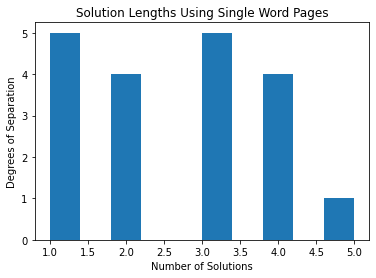

In [186]:
from matplotlib import pyplot as plt
ax = plt.hist(degreesMulti)


plt.title('Solution Lengths Using Single Word Pages')
plt.xlabel('Number of Solutions')
plt.ylabel('Degrees of Separation')

Text(0, 0.5, 'Degrees of Separation')

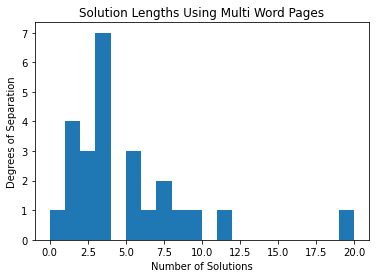

In [187]:
from matplotlib import pyplot as plt
ax = plt.hist(degreesSingle, bins = 20)


plt.title('Solution Lengths Using Multi Word Pages')
plt.xlabel('Number of Solutions')
plt.ylabel('Degrees of Separation')

In [183]:
averageMultiDegrees = sum(degreesMulti)/len(degreesMulti)
averageMultiDegrees

2.5789473684210527

In [184]:
averageSingleDegrees = sum(degreesSingle)/len(degreesSingle)
averageSingleDegrees

4.56

Text(0, 0.5, 'Degrees of Separation')

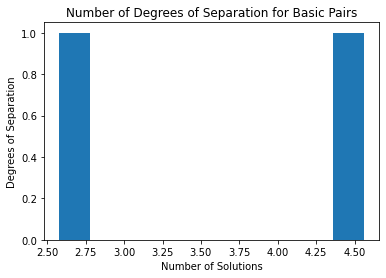

In [185]:
ax = plt.hist((averageSingleDegrees,averageMultiDegrees))


plt.title('Number of Degrees of Separation for Basic Pairs')
plt.xlabel('Number of Solutions')
plt.ylabel('Degrees of Separation')

In [68]:
#Originally trying to collect data by looping through pairs of page
#when an error would occur, however, it would break the entire loop, and sometimes
#require restarting the entire kernal
#this is why I switched to the above method of individualling running each pair
import time
origins = ["The Supremes","Education","Financial crisis","U.S. state","Hypothalamus"
,"Disney Channel","Pederasty","Smallpox","Ludwig van Beethoven","Prussia","Alchemy","Nickel"]
#            "Snow","Firefox"
#     "Mercury (planet)", "Leaf"
#            "Dysentery","Ludwig van Beethoven",
# "Mesothelioma","The Cosby Show","Playing card","Nas","Psychologist","Rahul Gandhi","Prussia","The Beatles","Alchemy","Vitamin D","Assassination of John F. Kennedy"
# ,"Democratic Republic of the Congo","Napoleon"]

targets = ["Emma Stone","Traffic collision","Tomato","Mixed martial arts","Card game","Kate Beckinsale","Instant messaging","Chemotherapy","Playing card","Rahul Gandhi","Byzantine Empire","Pressure"]
#            ,"Hormone"]

# ,"Pressure","HDMI","Rafael Nadal","Arrested Development (TV series)"
# ,"Jack Swagger","Nickel","Snow","Firefox","Colin Powell","New World","Leaf","Ayn Rand","Chicken","Olympic sports","Smallpox","Europe (band)","Centers for Disease Control and Prevention"]
# ,"Byzantine Empire","Noam Chomsky","Chemotherapy","Titanium","Malaria","EBay","Animation","Logo","Mind"]
# "The Cosby Show","Playing card"

degrees = []
nodes_expanded = []
len(targets)
for i in range(12):
    
    degree,expanded = 0,0
    try:
        print("trying",i)
        degree,expanded = findDistanceSummingDataCollection(origins[i],targets[i])
    except:
#         time.sleep(1)
        print("couldn't find answer for",i)
#         time.sleep(1)
#         findDistanceSummingDataCollection("Cat","Computer")
        pass
    finally:
        
        degrees.append(degree)
        nodes_expanded.append(expanded)


trying 0
Running findDistance
couldn't find answer for 0
trying 1
Running findDistance
couldn't find answer for 1
trying 2
Running findDistance
couldn't find answer for 2
trying 3
Running findDistance
couldn't find answer for 3
trying 4
Running findDistance
couldn't find answer for 4
trying 5
Running findDistance
couldn't find answer for 5
trying 6
Running findDistance
couldn't find answer for 6
trying 7
Running findDistance
couldn't find answer for 7
trying 8
Running findDistance
couldn't find answer for 8
trying 9
Running findDistance
couldn't find answer for 9
trying 10
Running findDistance
couldn't find answer for 10
trying 11
Running findDistance
couldn't find answer for 11
